In [52]:
!pip install pyspark


In [53]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CustomerBuyingPrediction") \
    .getOrCreate()

spark


In [54]:
df = spark.read.csv("customer_segmentation 2.csv"
 ,
    header=True,
    inferSchema=True
)

df.show(5)
df.printSchema()


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows
root
 |-- InvoiceNo: string (nullable = true)
 |-

In [55]:
df.columns


['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

In [56]:
df = df.dropna()


In [57]:
df.describe().show()


+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|            406829|            406829|              406829|            406829|         406829|           406829|            406829|     406829|
|   mean| 560617.1266447864|27430.341352504624|                NULL| 12.06130339774205|           NULL|  3.4604710185356|15287.690570239585|       NULL|
| stddev|13106.167694740181| 16403.57045262619|                NULL|248.69337001882366|           NULL|69.31516172321383| 1713.600303321594|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -8

In [58]:
df.printSchema()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [59]:
from pyspark.sql.functions import col

df = df.withColumn(
    "TransactionValue",
    col("Quantity") * col("UnitPrice")
)


In [60]:
from pyspark.sql.functions import sum, countDistinct, avg

customer_df = df.groupBy("CustomerID").agg(
    sum("TransactionValue").alias("TotalSpend"),
    countDistinct("InvoiceNo").alias("PurchaseFrequency"),
    sum("Quantity").alias("TotalQuantity"),
    avg("UnitPrice").alias("AvgUnitPrice"),
    countDistinct("StockCode").alias("UniqueProducts")
)


In [61]:
from pyspark.sql.functions import when

customer_df = customer_df.withColumn(
    "BuyingBehavior",
    when(col("TotalSpend") < 1000, "Low")
    .when(col("TotalSpend") < 3000, "Medium")
    .otherwise("High")
)


In [62]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[
        "TotalSpend",
        "PurchaseFrequency",
        "TotalQuantity",
        "AvgUnitPrice",
        "UniqueProducts"
    ],
    outputCol="features"
)

final_df = assembler.transform(customer_df)


In [63]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="BuyingBehavior",
    outputCol="label"
)

customer_df = label_indexer.fit(customer_df).transform(customer_df)


In [64]:
from pyspark.sql.functions import col

final_df = final_df.withColumnRenamed("BuyingBehavior", "label")

final_df.select("features", "label").show(3)



+--------------------+------+
|            features| label|
+--------------------+------+
|[109.950000000000...|   Low|
|[5178.95999999999...|  High|
|[2709.11999999999...|Medium|
+--------------------+------+
only showing top 3 rows


In [65]:
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)


In [66]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [67]:
from pyspark.ml.feature import StringIndexer

label_indexer = StringIndexer(
    inputCol="label",        # string: Low / Medium / High
    outputCol="label_index", # numeric
    handleInvalid="keep"
)

label_model = label_indexer.fit(train_df)

train_df = label_model.transform(train_df)
test_df = label_model.transform(test_df)



In [68]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [5, 8, 5, 3]

mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label_index",
    layers=layers,
    maxIter=100,
    seed=42
)

mlp_model = mlp.fit(train_df)
predictions = mlp_model.transform(test_df)


In [69]:
train_df.select("label", "label_index").show(5)
train_df.select("label_index").printSchema()


+------+-----------+
| label|label_index|
+------+-----------+
|   Low|        0.0|
|  High|        2.0|
|Medium|        1.0|
|   Low|        0.0|
|Medium|        1.0|
+------+-----------+
only showing top 5 rows
root
 |-- label_index: double (nullable = false)



from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [5, 8, 5, 3]

mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label_index",
    layers=layers,
    maxIter=100,
    seed=42
)

mlp_model = mlp.fit(train_df)
predictions = mlp_model.transform(test_df)


In [70]:
predictions.select("label", "prediction").show(5)


+------+----------+
| label|prediction|
+------+----------+
|Medium|       0.0|
|   Low|       0.0|
|   Low|       0.0|
|Medium|       0.0|
|   Low|       0.0|
+------+----------+
only showing top 5 rows


In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)



Accuracy: 0.6682750301568154


In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="weightedPrecision"
)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="weightedRecall"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="f1"
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="accuracy"
)

print("Accuracy:", accuracy_evaluator.evaluate(predictions))
print("Precision:", precision_evaluator.evaluate(predictions))
print("Recall:", recall_evaluator.evaluate(predictions))
print("F1 Score:", f1_evaluator.evaluate(predictions))


Accuracy: 0.6682750301568154
Precision: 0.4465915159310926
Recall: 0.6682750301568154
F1 Score: 0.5353931550352505


In [73]:
model_path = "/content/mlp_buying_behavior_model"

mlp_model.write().overwrite().save(model_path)


In [74]:
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

loaded_model = MultilayerPerceptronClassificationModel.load(model_path)


In [75]:
new_predictions = loaded_model.transform(test_df)

new_predictions.select("label", "prediction").show(5)


+------+----------+
| label|prediction|
+------+----------+
|Medium|       0.0|
|   Low|       0.0|
|   Low|       0.0|
|Medium|       0.0|
|   Low|       0.0|
+------+----------+
only showing top 5 rows


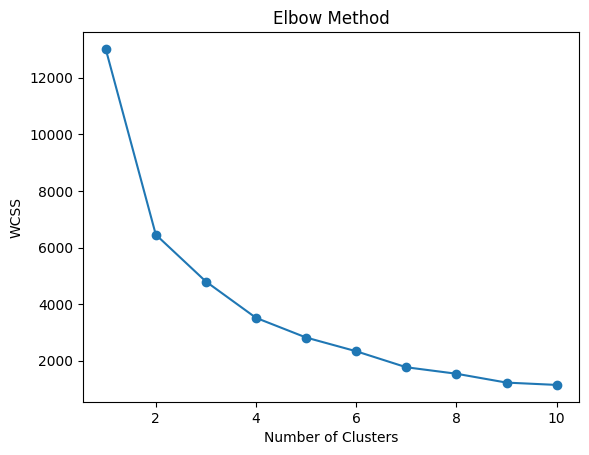

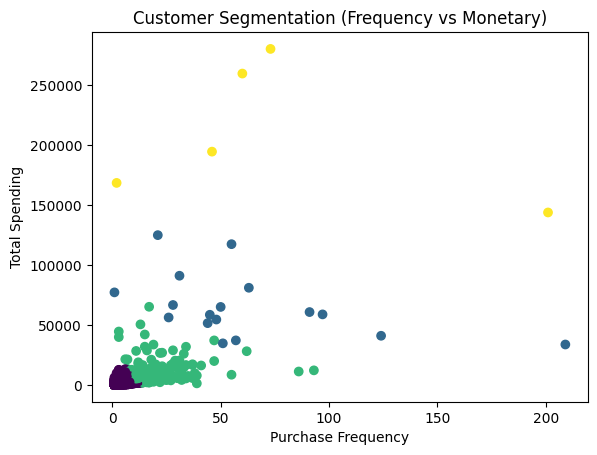

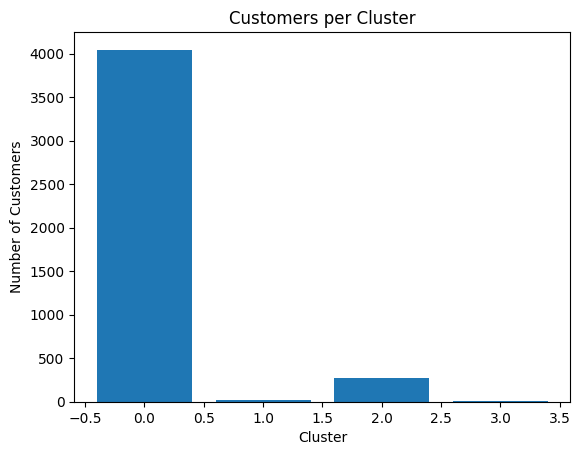

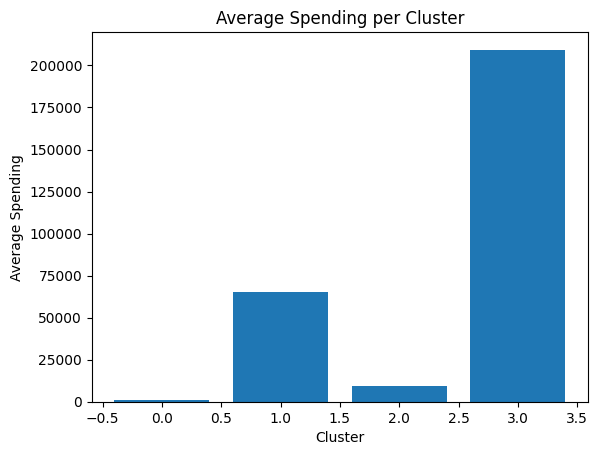

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv('/content/customer_segmentation 2.csv', encoding='latin1')

# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove returns / invalid values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# ===============================
# 2. Customer-Level Aggregation
# ===============================
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

customer_df.columns = ['CustomerID', 'Frequency', 'TotalQuantity', 'Monetary']

# ===============================
# 3. Feature Scaling
# ===============================
features = customer_df[['Frequency', 'TotalQuantity', 'Monetary']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# ===============================
# 4. Elbow Method Visualization
# ===============================
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# ===============================
# 5. KMeans Clustering
# ===============================
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)

# ===============================
# 6. Cluster Scatter Plot
# ===============================
plt.figure()
plt.scatter(customer_df['Frequency'],
            customer_df['Monetary'],
            c=customer_df['Cluster'])
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Spending')
plt.title('Customer Segmentation (Frequency vs Monetary)')
plt.show()

# ===============================
# 7. Cluster Size Visualization
# ===============================
cluster_counts = customer_df['Cluster'].value_counts().sort_index()

plt.figure()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customers per Cluster')
plt.show()

# ===============================
# 8. Average Spending per Cluster
# ===============================
cluster_spending = customer_df.groupby('Cluster')['Monetary'].mean()

plt.figure()
plt.bar(cluster_spending.index, cluster_spending.values)
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.title('Average Spending per Cluster')
plt.show()


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


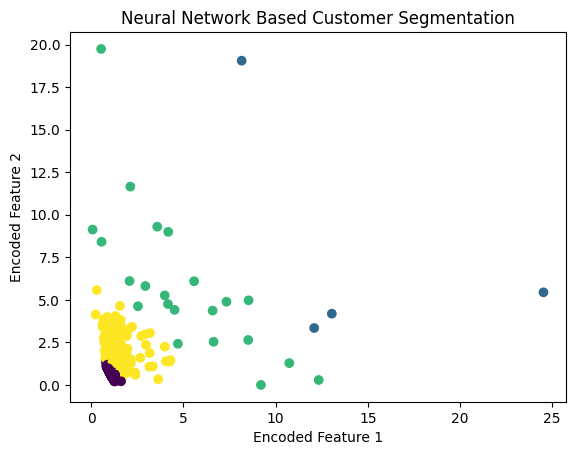

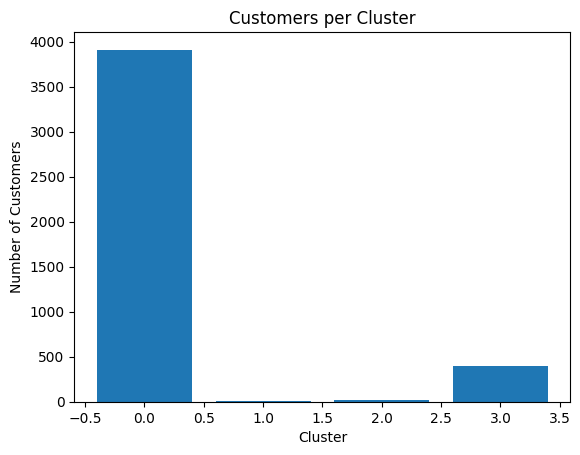

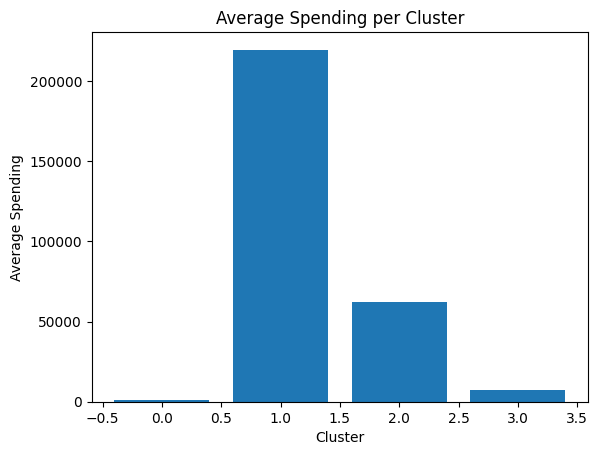

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv('/content/customer_segmentation 2.csv', encoding='latin1')

# Clean data
df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# ===============================
# 2. Customer-Level Features
# ===============================
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

customer_df.columns = ['CustomerID', 'Frequency', 'TotalQuantity', 'Monetary']

# ===============================
# 3. Feature Scaling
# ===============================
X = customer_df[['Frequency', 'TotalQuantity', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# 4. Autoencoder (Neural Network)
# ===============================
input_layer = Input(shape=(X_scaled.shape[1],))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(X_scaled.shape[1], activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X_scaled, X_scaled,
                epochs=30,
                batch_size=32,
                shuffle=True,
                verbose=0)

# ===============================
# 5. Get Encoded Features
# ===============================
encoded_features = encoder.predict(X_scaled)

# ===============================
# 6. KMeans on Encoded Features
# ===============================
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(encoded_features)

# ===============================
# 7. Neural Network Cluster Visualization
# ===============================
plt.figure()
plt.scatter(encoded_features[:, 0],
            encoded_features[:, 1],
            c=customer_df['Cluster'])
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.title('Neural Network Based Customer Segmentation')
plt.show()

# ===============================
# 8. Cluster Size Visualization
# ===============================
cluster_counts = customer_df['Cluster'].value_counts().sort_index()

plt.figure()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customers per Cluster')
plt.show()

# ===============================
# 9. Average Spending per Cluster
# ===============================
cluster_spending = customer_df.groupby('Cluster')['Monetary'].mean()

plt.figure()
plt.bar(cluster_spending.index, cluster_spending.values)
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.title('Average Spending per Cluster')
plt.show()


In [78]:
# Save models
autoencoder.save("autoencoder_model.h5")
encoder.save("encoder_model.h5")


In [79]:
from tensorflow.keras.models import load_model

autoencoder = load_model(
    "autoencoder_model.h5",
    compile=False
)

encoder = load_model(
    "encoder_model.h5",
    compile=False
)



In [80]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

autoencoder = load_model(
    "autoencoder_model.h5",
    custom_objects={"mse": MeanSquaredError()}
)


In [81]:
autoencoder.save("autoencoder_model.keras")
encoder.save("encoder_model.keras")


In [82]:
autoencoder = load_model("autoencoder_model.keras")
encoder = load_model("encoder_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [83]:
import os
os.listdir()



['.config',
 'encoder_model.keras',
 'encoder_model.h5',
 'customer_segmentation 2.csv',
 'mlp_buying_behavior_model',
 '.ipynb_checkpoints',
 'autoencoder_model.h5',
 'autoencoder_model.keras',
 'sample_data']

In [84]:
from tensorflow.keras.models import load_model

autoencoder = load_model("autoencoder_model.h5", compile=False)
encoder = load_model("encoder_model.h5", compile=False)


In [85]:
# After training
autoencoder.save("autoencoder_model.h5")
encoder.save("encoder_model.h5")


In [86]:
autoencoder = load_model("autoencoder_model.h5", compile=False)
encoder = load_model("encoder_model.h5", compile=False)


In [87]:
autoencoder.save("autoencoder_model.h5")
encoder.save("encoder_model.h5")


In [88]:
print(os.listdir())


['.config', 'encoder_model.keras', 'encoder_model.h5', 'customer_segmentation 2.csv', 'mlp_buying_behavior_model', '.ipynb_checkpoints', 'autoencoder_model.h5', 'autoencoder_model.keras', 'sample_data']


In [89]:
from tensorflow.keras.models import load_model

autoencoder = load_model("autoencoder_model.h5", compile=False)
encoder = load_model("encoder_model.h5", compile=False)


In [90]:
import os
print(os.getcwd())
print(os.listdir())


/content
['.config', 'encoder_model.keras', 'encoder_model.h5', 'customer_segmentation 2.csv', 'mlp_buying_behavior_model', '.ipynb_checkpoints', 'autoencoder_model.h5', 'autoencoder_model.keras', 'sample_data']


In [91]:
import os
os.makedirs("models", exist_ok=True)


In [92]:
print(os.listdir())


['.config', 'encoder_model.keras', 'encoder_model.h5', 'models', 'customer_segmentation 2.csv', 'mlp_buying_behavior_model', '.ipynb_checkpoints', 'autoencoder_model.h5', 'autoencoder_model.keras', 'sample_data']


In [93]:
autoencoder.save("models/autoencoder_model.h5")
encoder.save("models/encoder_model.h5")


In [94]:
print(os.listdir("models"))


['encoder_model.h5', 'autoencoder_model.h5']


In [95]:
from tensorflow.keras.models import load_model

autoencoder = load_model("models/autoencoder_model.h5", compile=False)
encoder = load_model("models/encoder_model.h5", compile=False)


In [96]:
import os

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

autoencoder.save(f"{MODEL_DIR}/autoencoder_model.h5")
encoder.save(f"{MODEL_DIR}/encoder_model.h5")

autoencoder = load_model(f"{MODEL_DIR}/autoencoder_model.h5", compile=False)


In [97]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CustomerSegmentation-Step1") \
    .getOrCreate()


In [98]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("/content/customer_segmentation 2.csv")

df.show(5)


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows


In [99]:
df.printSchema()

from pyspark.sql.functions import col

df.select([
    col(c).isNull().alias(c) for c in df.columns
]).show()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|    false|    false|      false|   false|      false|    false|     false|  false|
|    false|    false|      false|   false|      false|    false|     false|  false|
|    false|    false|      false|   false|      false|    false|     false|  false|
|    false|    false|      false|   false|      false|    false|     false|  false|
|    false|    false|      false|   false|      false|    false|     false

In [100]:
# Remove rows with missing CustomerID
df_clean = df.dropna(subset=["CustomerID"])

# Remove invalid transactions
df_clean = df_clean.filter(
    (col("Quantity") > 0) & (col("UnitPrice") > 0)
)


In [101]:
from pyspark.sql.functions import expr

df_clean = df_clean.withColumn(
    "TotalPrice",
    expr("Quantity * UnitPrice")
)


In [102]:
from pyspark.sql.functions import countDistinct, sum as spark_sum

customer_df = df_clean.groupBy("CustomerID").agg(
    countDistinct("InvoiceNo").alias("Frequency"),
    spark_sum("Quantity").alias("TotalQuantity"),
    spark_sum("TotalPrice").alias("Monetary")
)

customer_df.show(5)


+----------+---------+-------------+------------------+
|CustomerID|Frequency|TotalQuantity|          Monetary|
+----------+---------+-------------+------------------+
|     17389|       34|         7612|31833.679999999997|
|     14450|        3|          241|            483.25|
|     15727|        7|         3065|           5178.96|
|     13285|        4|         2051|2709.1199999999994|
|     14570|        2|           95|218.05999999999997|
+----------+---------+-------------+------------------+
only showing top 5 rows


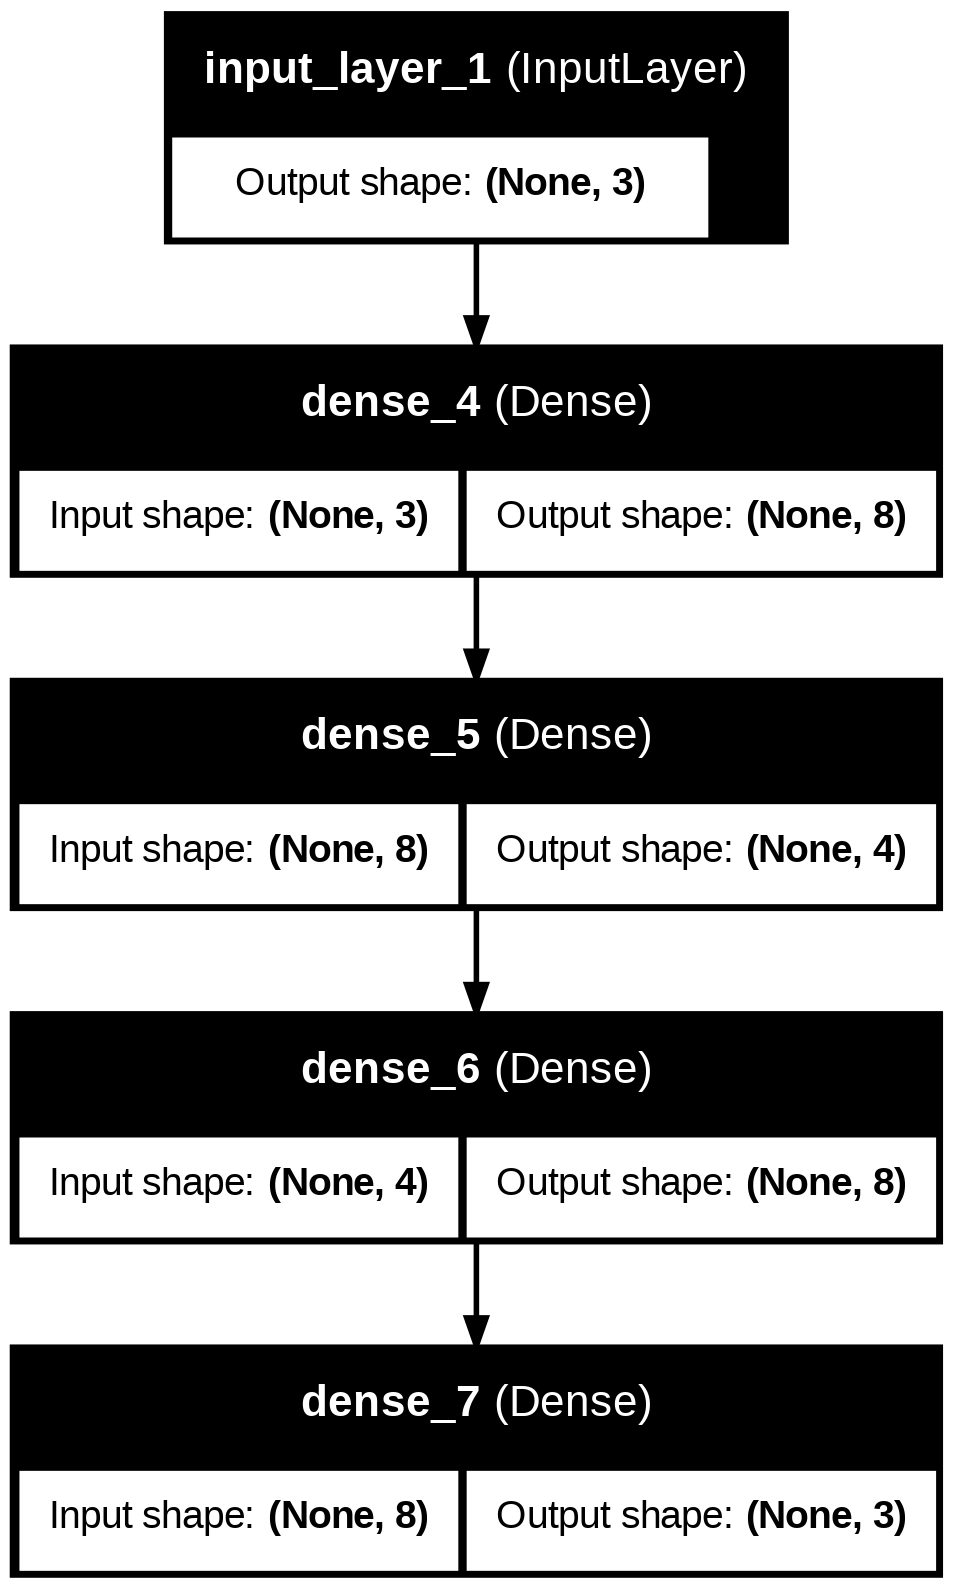

In [103]:
from tensorflow.keras.utils import plot_model

plot_model(
    autoencoder,
    to_file="autoencoder_architecture.png",
    show_shapes=True,
    show_layer_names=True
)


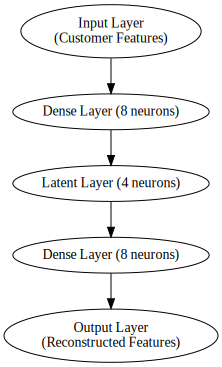

In [104]:
from graphviz import Digraph

dot = Digraph(comment='Autoencoder Neural Network')

dot.node('I', 'Input Layer\n(Customer Features)')
dot.node('E1', 'Dense Layer (8 neurons)')
dot.node('E2', 'Latent Layer (4 neurons)')
dot.node('D1', 'Dense Layer (8 neurons)')
dot.node('O', 'Output Layer\n(Reconstructed Features)')

dot.edges([
    ('I', 'E1'),
    ('E1', 'E2'),
    ('E2', 'D1'),
    ('D1', 'O')
])

dot


In [105]:
customer_pd = customer_df.toPandas()


In [106]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

customer_pd = customer_df.toPandas()

# Re-extract features from the pandas DataFrame and scale them
features_for_scaling = customer_pd[['Frequency', 'TotalQuantity', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_scaling)

latent_features = encoder.predict(X_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
customer_pd['Cluster'] = kmeans.fit_predict(latent_features)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


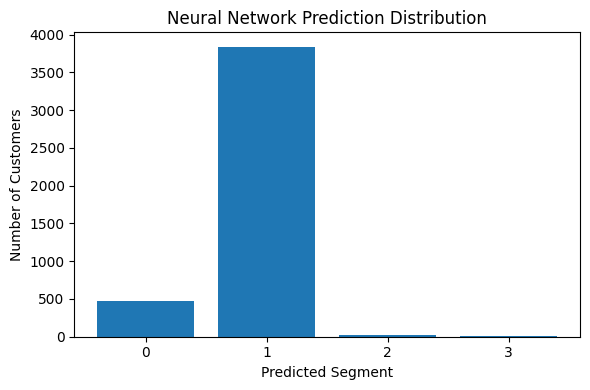

In [107]:
segment_counts = customer_pd['Cluster'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(segment_counts.index.astype(str), segment_counts.values)
plt.xlabel("Predicted Segment")
plt.ylabel("Number of Customers")
plt.title("Neural Network Prediction Distribution")
plt.tight_layout()
plt.show()
